In [3]:
import pandas as pd
import time
import datetime
import numpy as np


import prob_tree
import kTree
import csv
from fractions import Fraction
import graphviz
import tree
from kTree import ktree_main

import sys
import generators
import numpy as np
import math
from data import Data
from datetime import datetime, timedelta

import os
import pickle
import json


data_train1 = pd.read_csv('./input_data/Future/20190620/IH1906.CFFEX.txt',header=0)

In [ ]:
###Read the train data to get the thresholds for classification

date_test=20180619
freq=1
num_train_days=1


date_test_d = datetime(year=int(str(date_test)[0:4]), month=int(str(date_test)[4:6]), day=int(str(date_test)[6:8]))
date_date =  date_test_d-timedelta(days=1)  
date = 10000*date_date.year + 100*date_date.month + date_date.day
i = 0
return_train=[]

while i<num_train_days:
    path = './input_data/Future/mid_volume_train_IH_1min_'+str(date)+'.txt'
    #path = './input_data/Future/2mid_volume_train_IC_'+str(date)+'.txt'
    date_date = datetime(year=int(str(date)[0:4]), month=int(str(date)[4:6]), day=int(str(date)[6:8]))
    if os.access(path, os.F_OK):
        i += 1  
        f = open(path, "rb")  
        price_train = pickle.load(f)
        f.close()
        price_index = [x * freq for x in list(range(int(len(price_train)/freq)))]
        price_train_ = price_train.iloc[price_index]

        price_train_1 = price_train_[:(len(price_train_)-1)]
        price_train_2 = price_train_[1:len(price_train_)]
        price_train_1.index = price_train_2.index
        return_train_ = (price_train_2/price_train_1-1)*100
        locals()['return_train'+str(i)] = return_train_.tolist()
        return_train.extend(locals()['return_train'+str(i)])
    date_date =  date_date-timedelta(days=1) 
    date = 10000*date_date.year + 100*date_date.month + date_date.day
    
    
return_train_class_total = []
thres1 = np.percentile(return_train,25)
thres2 = np.percentile(return_train,50)
thres3 = np.percentile(return_train,75)
for d in return_train:
    v = None
    if d <= thres1:
        v = 0
    elif thres1 < d and d <= thres2:
        v = 1
    elif thres2 < d and d <= thres3:
        v = 2
    elif d > thres3:
        v = 3
    return_train_class_total.append(v)

# fileObject = open('return_class_train.txt', 'w')
# fileObject.write('[')
# for ip in return_train_class_total[:-1]:
#     ip=str(ip)
#     fileObject.write(ip)
#     fileObject.write(',')
# fileObject.write(str(return_train_class_total[-1]))
# fileObject.write(']')
# fileObject.close()



In [5]:
###Read the test data and make classification

date_test=20180619
freq=1

path = './input_data/Future/mid_volume_train_IH_1min_'+str(date_test)+'.txt'
#path = './input_data/Future/2mid_volume_train_IC_'+str(date_test)+'.txt'
f = open(path, "rb")  
price_test = pickle.load(f)
price_index = [x * freq for x in list(range(int(len(price_test)/freq)))]
price_test_ = price_test.iloc[price_index]
price_test_1 = price_test_[:(len(price_test_)-1)]
price_test_2 = price_test_[1:len(price_test_)]
price_test_1.index = price_test_2.index
return_test = (price_test_2/price_test_1-1)*100
price_test_1=price_test_1.tolist()
return_test = return_test.tolist()

return_test_class_total = []

for d in return_test:
    v = None
    if d <= thres1:
        v = 0
    elif thres1 < d and d <= thres2:
        v = 1
    elif thres2 < d and d <= thres3:
        v = 2
    elif d > thres3:
        v = 3
    return_test_class_total.append(v)

return_test_class_input = return_test_class_total[(10-10):]
return_test_class_real = return_test_class_total[10:]
return_test_real = return_test[10:]
price_test_real = price_test_1[10:]

In [5]:
len(return_test)

28800

In [245]:
###Mean reverting strategy using weighted return as signal

portf_value = []
portf_value.append(1.)
pt_value=0.
len_test= len(return_test)
pos0=0
pos1=0
poscum=0
maxpos=5
pos=[]
beta=10
correct=0
num_zero=0
#profit=[]
for i in range(10,len_test-1): #4788-1
    signal=10*return_test[i]+9*return_test[i-1]+8*return_test[i-2]+7*return_test[i-3]+\
    6*return_test[i-4]+5*return_test[i-5]+4*return_test[i-6]+3*return_test[i-7]+\
    2*return_test[i-8]+1*return_test[i-9]
    #print(signal)
    if(signal>0):
        pos1=-1
        #pos1=beta*signal
        pos.append(pos1)
        pt_value = pt_value+pos1*price_test_1[i+1]*return_test[i+1]/100
        #print([+1,return_test_class_predicted_one[i+1],price_test_1[-len_test+1+i]*return_test[-len_test+1+i]/100,price_test_1[-len_test+1+i],return_test[-len_test+1+i]/100])
        if(return_test[i+1]<0): correct+=1
    elif(signal<0):
        pos1=1
        #pos1=beta*signal
        pos.append(pos1)
        pt_value = pt_value+pos1*price_test_1[i+1]*return_test[-len_test+1+i]/100            
        #print([-1,return_test_class_predicted_one[i+1],-price_test_1[-len_test+1+i]*return_test[-len_test+1+i]/100,price_test_1[-len_test+1+i],return_test[-len_test+1+i]/100])
        if(return_test[i+1]>0): correct+=1
    if(return_test[i+1]==0):num_zero+=1
            
    #profit.append(abs(price_test_1[-len_test+1+i]*return_test[-len_test+1+i]/100))  
    poscum=poscum+abs(pos1-pos0)
    #print(poscum)
    pos0=pos1
    portf_value.append(pt_value)

In [21]:
###Mean reverting strategy using weighted return as signal (strategy with threshold):

portf_value = []
portf_value.append(1.)
pt_value=0.
len_test= len(return_test)
pos0=0
pos1=0
poscum=0
maxpos=5
pos=[]
beta=10
correct=0
num_zero=0
signal_list=[]
count=0
N_quantile=200
p1=99
p2=1
#profit=[]
for i in range(10,N_quantile+10-1): #4788-1
    signal=10*return_test[i]+9*return_test[i-1]+8*return_test[i-2]+7*return_test[i-3]+\
    6*return_test[i-4]+5*return_test[i-5]+4*return_test[i-6]+3*return_test[i-7]+\
    2*return_test[i-8]+1*return_test[i-9]
    signal_list.append(signal)
    
for i in range(N_quantile+10-1,len_test-1): #4788-1
    signal=10*return_test[i]+9*return_test[i-1]+8*return_test[i-2]+7*return_test[i-3]+\
    6*return_test[i-4]+5*return_test[i-5]+4*return_test[i-6]+3*return_test[i-7]+\
    2*return_test[i-8]+1*return_test[i-9]
    #print(signal)
    if(signal>np.percentile(signal_list[(-200):(-1)],p1)):
        pos1=-1
        #pos1=-beta*signal
        pos.append(pos1)
        pt_value = pt_value+pos1*price_test_1[i+1]*return_test[i+1]/100
        #print([+1,return_test_class_predicted_one[i+1],price_test_1[-len_test+1+i]*return_test[-len_test+1+i]/100,price_test_1[-len_test+1+i],return_test[-len_test+1+i]/100])
        if(return_test[i+1]<0): correct+=1
        count+=1
        if(return_test[i+1]==0):num_zero+=1
    elif(signal<np.percentile(signal_list[(-200):(-1)],p2)):
        pos1=1
        #pos1=-beta*signal
        pos.append(pos1)
        pt_value = pt_value+pos1*price_test_1[i+1]*return_test[-len_test+1+i]/100            
        #print([-1,return_test_class_predicted_one[i+1],-price_test_1[-len_test+1+i]*return_test[-len_test+1+i]/100,price_test_1[-len_test+1+i],return_test[-len_test+1+i]/100])
        if(return_test[i+1]>0): correct+=1
        count+=1
        if(return_test[i+1]==0):num_zero+=1
    else:
        pos1=0
        pos.append(pos1)

#     else:
#         pos1=pos0
#         pos.append(pos1)
#         pt_value = pt_value+pos1*price_test_1[i+1]*return_test[-len_test+1+i]/100 
#         if(np.sign(signal)==np.sign(return_test[i+1])):correct+=1
#         count+=1
#         if(return_test[i+1]==0):num_zero+=1


    
    #profit.append(abs(price_test_1[-len_test+1+i]*return_test[-len_test+1+i]/100))  
    poscum=poscum+abs(pos1-pos0)
    #print(poscum)
    pos0=pos1
    signal_list.append(signal)
    portf_value.append(pt_value)
    
    #print([pos1,price_test_1[i+1],return_test[-len_test+1+i],poscum,pos1*price_test_1[i+1]*return_test[-len_test+1+i]/100,pt_value])



In [22]:
print(correct)
correct/(len(portf_value)-num_zero)
print(correct/(count-num_zero))
count

621
0.6349693251533742


1147

<Figure size 432x288 with 0 Axes>

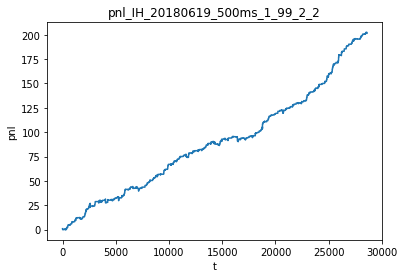

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
plt.plot(portf_value)
plt.xlabel('t')
plt.ylabel('pnl')
name="pnl_IH_"+str(date_test)+'_500ms_'+str(p2)+'_'+str(p1)+'_2_2'
plt.title(name)
#plt.savefig(name+".png")
plt.figure()

<Figure size 432x288 with 0 Axes>

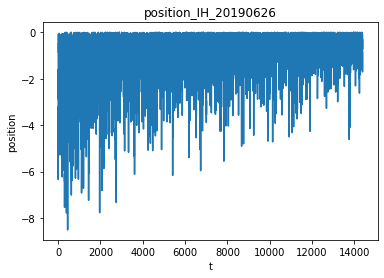

<Figure size 432x288 with 0 Axes>

In [37]:
plt.plot(pos)
#plt.plot(range(24000,26000),pos[24000:26000])
plt.xlabel('t')
plt.ylabel('position')
name="position_IH_"+str(date_test)
plt.title(name)
#plt.savefig(name+".png")
plt.figure()